# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
#color = sns.color_palette()
#sns.palplot(sns.color_palette('colorblind'))
sns.set_palette('dark')

%matplotlib inline

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# cross validation 
from sklearn.model_selection import train_test_split

# hyper-parameter tuning
from sklearn.grid_search import GridSearchCV

# preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, OneHotEncoder

# linear models
from sklearn.linear_model import LogisticRegression

# non-linear models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

# ensemble models
from sklearn.ensemble import RandomForestClassifier

# pipeline
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import classification_report, confusion_matrix, log_loss


/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ikononenko/tensorflow/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii


In [3]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [4]:
train_df = pd.read_json('train.json').reset_index(drop=True)
test_df = pd.read_json('test.json').reset_index(drop=True)

In [5]:
def clean_numeric_variables(df, column):
    min_value, max_value = np.percentile(df['%s' % column], [1, 99]).tolist()
    df['%s' % column] = np.where(df['%s' % column] < min_value, min_value, df['%s' % column])
    df['%s' % column] = np.where(df['%s' % column] > max_value, max_value, df['%s' % column])

In [6]:
clean_numeric_variables(train_df, 'latitude')
clean_numeric_variables(train_df, 'longitude')

In [7]:
train_df['price_log'] = np.log(train_df.price)

In [8]:
def clean_addresses(df, column):
    df['%s' % column] = [remove_accents(line) for line in df['%s' % column]] 
    df['%s' % column] = df['%s' % column].map(lambda x: ' '.join(x.strip('!@#$%^&*()-_+=;,./\\\'\t')\
                                                    .replace("'",'').lower()\
                                                    .replace(' street', ' st').replace(' avenue', ' ave')\
                                                    .replace(' road', ' rd').replace(' boulevard', ' blvd')\
                                                    .replace(' east', ' e').replace(' west', ' w')\
                                                    .replace('east ', 'e ').replace('west ', 'w ').split()))
    return df

In [9]:
clean_addresses(train_df, 'display_address')
clean_addresses(train_df, 'street_address')

print "Done"

Done


In [10]:
bldg_id_counts = train_df.building_id.value_counts()
train_df['listings_in_bldg'] = train_df.building_id.map(lambda b: bldg_id_counts[b] if b != '0' else 1)

In [11]:
manager_id_counts = train_df.manager_id.value_counts()
train_df['listings_per_manager'] = train_df.manager_id.map(lambda b: manager_id_counts[b] if b != '0' else 1)

In [12]:
def do_lem(str):
    return " ".join([WordNetLemmatizer().lemmatize(word) for word in str.split(" ")])

def do_stem(str):
    return " ".join([PorterStemmer().stem(word) for word in str.split(" ")])

In [13]:
train_df.description = [remove_accents(line) for line in train_df.description] 

train_df.description = [re.sub(r'[()?!@#$%^&*-;\'\"]', "", line).replace(","," ")\
                                 .replace("<br >", "").replace("<br />","").replace("<p>","").replace("</p>","")\
                                 .replace("<a  website_redacted", "")\
                                 .replace("apartment", "").replace("bedroom", "").replace("bathroom", "")
                                 .lower().strip() for line in train_df.description]

train_df.description = [re.sub(re.compile(r'\s+'), " ", line) for line in train_df.description]
train_df.description = [do_lem(line) for line in train_df.description]

In [14]:
def clean_features(alist):
    if len(alist) == 0:
        return alist
    return [x.lower().strip('!@#$%^&*()-_+=;,./\\\'\t').replace(' ', '').replace('-','') for x in alist]

In [15]:
train_df.features = train_df.features.apply(lambda alist: clean_features(alist))

In [16]:
train_df['num_photos'] = train_df.photos.apply(len)
train_df['num_features'] = train_df.features.apply(len)
train_df['description_size'] = train_df.description.apply(lambda x: len(x.split(" ")))

train_df['created'] = pd.to_datetime(train_df.created)
train_df['month'] = train_df.created.dt.month
train_df['hod'] = train_df.created.dt.hour
train_df['dow'] = train_df.created.dt.dayofweek

In [17]:
my_features = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price_log', 
               'listings_in_bldg', 'listings_per_manager', 
               'num_photos', 'num_features', 'description_size', 'hod', 'dow']

X = train_df[my_features]
y = train_df['interest_level']

X.head()

,bathrooms,bedrooms,latitude,longitude,price_log,listings_in_bldg,listings_per_manager,num_photos,num_features,description_size,hod,dow
0,1.5,3,40.7145,-73.9425,8.006368,3,90,5,0,82,7,4
1,1.0,2,40.7947,-73.9667,8.606119,24,86,11,5,1,12,6
2,1.0,1,40.7388,-74.0018,7.955074,58,134,8,4,88,3,6
3,1.0,1,40.7539,-73.9677,8.094073,99,191,3,2,51,2,0
4,1.0,4,40.8241,-73.9493,8.116716,1,15,3,1,61,1,3


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Linear models

In [19]:
%%time
clf = LogisticRegression()
clf.fit(X_train, y_train)
print('LogisticRegression score: %f' % clf.score(X_test, y_test))

LogisticRegression score: 0.687468
CPU times: user 1.82 s, sys: 19.3 ms, total: 1.84 s
Wall time: 1.84 s


             precision    recall  f1-score   support

       high       0.42      0.04      0.07       772
        low       0.71      0.96      0.82      6773
     medium       0.37      0.12      0.18      2326

avg / total       0.61      0.69      0.61      9871

Confusion matrix, without normalization
[[  30  565  177]
 [  12 6488  273]
 [  29 2029  268]]


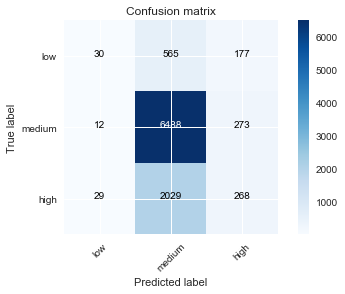

In [20]:
y_prediction = clf.predict(X_test)
print(classification_report(y_test, y_prediction))
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

## Non-linear models

In [21]:
%%time
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
print('Decision Trees score: %f' % clf.score(X_test, y_test))

Decision Trees score: 0.660825
CPU times: user 409 ms, sys: 5.7 ms, total: 415 ms
Wall time: 414 ms


             precision    recall  f1-score   support

       high       0.27      0.28      0.28       772
        low       0.80      0.80      0.80      6773
     medium       0.39      0.39      0.39      2326

avg / total       0.66      0.66      0.66      9871

Confusion matrix, without normalization
[[ 220  251  301]
 [ 273 5405 1095]
 [ 317 1111  898]]


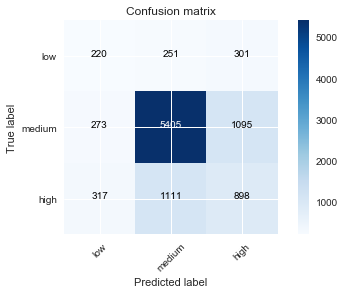

In [22]:
y_prediction = clf.predict(X_test)
print(classification_report(y_test, y_prediction))
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

## Ensemble models

In [23]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
print('RandomForestClassifier score: %f' % clf.score(X_test, y_test))

# prev: 0.733259

RandomForestClassifier score: 0.731638
CPU times: user 1min 5s, sys: 1.43 s, total: 1min 6s
Wall time: 1min 6s


             precision    recall  f1-score   support

       high       0.49      0.23      0.31       772
        low       0.78      0.94      0.85      6773
     medium       0.51      0.30      0.37      2326

avg / total       0.69      0.73      0.70      9871

Confusion matrix, without normalization
[[ 175  301  296]
 [  40 6356  377]
 [ 140 1495  691]]


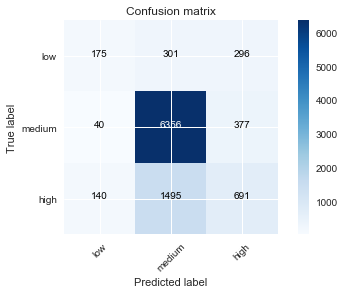

In [24]:
y_prediction = clf.predict(X_test)
print(classification_report(y_test, y_prediction))
plot_confusion_matrix(confusion_matrix(y_test, y_prediction), classes=['low', 'medium', 'high'])

# Submission saving

Submissions are evaluated using the multi-class logarithmic loss. Submit a set of predicted probabilities (one for every listing).

See details here: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries#evaluation

In [25]:
X = train_df[my_features]
y = clf.predict_proba(X)

In [26]:
import datetime
today = datetime.date.today().strftime("%d-%m-%Y")

In [27]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{u'high': 0, u'low': 1, u'medium': 2}

In [28]:
submission = pd.DataFrame()
submission['listing_id'] = train_df['listing_id']
for label in ['high', 'medium', 'low']:
    submission[label] = y[:, labels2idx[label]]
submission.to_csv('submission_%s.csv' % today, index=False)

In [29]:
submission.head()

,listing_id,high,medium,low
0,7211212,0.03200,0.75700,0.211
1,7150865,0.02200,0.08400,0.894
2,6887163,0.63825,0.13675,0.225
3,6888711,0.00400,0.02700,0.969
4,6934781,0.00100,0.05700,0.942
